<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw14/Homework14_meta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 435, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 435 (delta 114), reused 82 (delta 78), pack-reused 242
Receiving objects: 100% (435/435), 70.44 MiB | 28.38 MiB/s, done.
Resolving deltas: 100% (203/203), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=30522 sha256=bc56a59d07caae6c11a17599290528e02ada2cc893c406d5f5554ea13b5b0bf7
  Stored in directory: /tmp/pip-ephem-wheel-cache-roxxvqv7/wheels/55/59/29/0fb1c6356521

In [2]:
from dul_2021.utils.hw14_utils import *

In [3]:
!pip install higher

In [4]:
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import higher
import numpy as np

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data

Here we will work MNIST dataset which is already preprocessed for meta learning. This dataset comes in a dataloader from. Train loader yields a pair of batch of images (`[2 * N_way * k_shot, 1, 28, 28]`) and batch of labeles (`[2 * N_way * k_shot]`). Where `N_way` means number of classes in each task and `k_shot` means number of samples for each class. Both images and labeles are concatenation of support set (train) and query set (test). You can split them with `split_batch(imgs, targets)`.

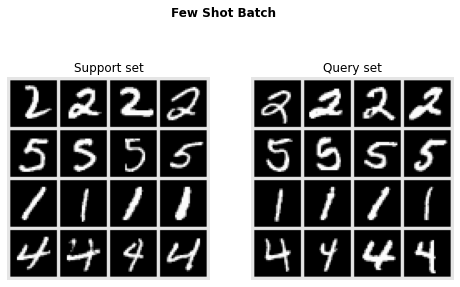

In [ ]:
# data sample example
show_imgs()

# Bonus. [ProtoMaml](https://arxiv.org/pdf/1903.03096.pdf)

A problem of MAML is how to design the output classification layer. In case all tasks have a different number of classes, we need to initialize the output layer with zeros or randomly in every iteration. Even if we always have the same number of classes, we just start from random predictions. This requires several inner loop steps to reach a reasonable classification result. To overcome this problem we can use prototypes to initialize our output layer to have a strong initialization. Thereby, it can be shown that the softmax over euclidean distances can be reformulated as a linear layer with softmax. To see this, let's first write out the negative Euclidean distance between a feature vector $f_{\theta}(\mathbf{x}^{*})$ of a new data point $\mathbf{x}^{*}$ to a prototype $\mathbf{v}_c$ of class $c$:

$$
-||f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c||^2=-f_{\theta}(\mathbf{x}^{*})^Tf_{\theta}(\mathbf{x}^{*})+2\mathbf{v}_c^{T}f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c^T\mathbf{v}_c
$$

We perform the classification across all classes $c\in\mathcal{C}$ and take a softmax on the distance. Hence, any term that is the same for all classes can be removed without changing the output probabilities. In the equation above, this is true for $-f_{\theta}(\mathbf{x}^{*})^Tf_{\theta}(\mathbf{x}^{*})$ since it is independent of any class prototype. Thus, we can write:

$$
-||f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c||^2=2\mathbf{v}_c^{T}f_{\theta}(\mathbf{x}^{*})-||\mathbf{v}_c||^2+\text{constant}
$$

Taking a second look at the equation above, it looks a lot like a linear layer. For this, we use $\mathbf{W}_{c,\cdot}=2\mathbf{v}_c$ and $b_c=-||\mathbf{v}_c||^2$ which gives us the linear layer $\mathbf{W}f_{\theta}(\mathbf{x}^{*})+\mathbf{b}$. Hence, if we initialize the output weight with twice the prototypes, and the biases by the negative squared L2 norm of the prototypes, we start with a Prototypical Network. MAML allows us to adapt this layer and the rest of the network further. 

* We will work with 2-way 4-shot classifications during training and 2-way 4-shot classification during test. However, dataloader will yield larger batches, which you need to reshape into `[batch_size, 2 * n-way * k-shot, 1, 28, 28]`

* You can use architecture from practice

* You can use higher or use first order approximation of gradients. This means that the second-order gradients are ignored, and we can calculate the outer loop gradients (line 10 in algorithm 2) simply by calculating the gradients with respect to $\theta_i'$ and use those as an update to $\theta$. Hence, the new update rule becomes:

$$
\theta\leftarrow\theta-\beta\sum_{\mathcal{T}_i\sim p(\mathcal{T})}\nabla_{\theta_i'}\mathcal{L}_{\mathcal{T}_i}(f_{\theta_i'})
$$

Note the change of $\theta$ to $\theta_i'$ for $\nabla$.


**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. Model with a `adapt_few_shots` method

**adapt_few_shots**

```
@torch.no_grad()
def adapt_few_shots(self, batch, dloader):
    """
    batch: n-way_test k-shot_test batch (pair) of images ([k_shot_test * n-way_test, 1, 28, 28]) \\
            and labeles [k_shot_test * n-way_test])
    dloader: dataloader for the test set. yields batches of images ([batch_size, 1, 28, 28])\\
              with their labelel ([batch_size])

     returns pred: np.array of predicted classed for each images in dloader (don't shuffle it)
    """
    
    return pred
```

## Main class

In [70]:
class Encoder(nn.Module):
  def __init__(self, latent_dim=16, hidden_dim=64):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1),
                              nn.ReLU(),
                              nn.Conv2d(32, hidden_dim, 3, 2, 1),
                              nn.ReLU(),
                              nn.Conv2d(hidden_dim, hidden_dim, 3, 2, 1),
                              nn.ReLU(),
                              nn.Conv2d(hidden_dim, hidden_dim, 3, 2, 1),
                              nn.ReLU(),
                              nn.Conv2d(hidden_dim, hidden_dim, 3, 2, 1),
                              nn.ReLU(),
                              nn.Conv2d(hidden_dim, hidden_dim, 3, 2, 1))
    
    self.lin = nn.Sequential(nn.Flatten(),
                             nn.Linear(hidden_dim, latent_dim))


  def forward(self, x):
    x = self.conv(x)
    return self.lin(x)

In [71]:
class ProtoMaml(nn.Module):
  def __init__(self, latent_dim=16):
    super().__init__()
    self.lat_dim = latent_dim
    self.inner_update = 2
    self.copy_models_num = 8

    self.ces = nn.CrossEntropyLoss()
    self.encoder = Encoder(latent_dim)
    self.opt = Adam(self.encoder.parameters(), 1e-3)
    
    for p in self.encoder.parameters():
      p.grad = torch.zeros_like(p.data)

  def get_centroids(self, x, labels):
    uniq, idx = np.unique(labels, return_inverse=True)
    centroids = torch.empty((len(uniq), self.lat_dim), device=device)    
    
    for i, _ in enumerate(uniq):
      centroids[i] = x[idx == i].mean(dim=0)

    return centroids, uniq

  def perceive(self, xs, ls, xq, lq):
    """
      xs, ls -- support images and labels
      xq, lq -- query images and labels
    """
    # Split on few mini-tasks
    xs, xq = map(lambda x: torch.chunk(x, self.copy_models_num, 0), [xs, xq])
    ls, lq = map(lambda x: np.split(x, self.copy_models_num), [ls, lq])
    total_loss = 0
    
    # Compute gradient for every mini-task and average them as gradient of current weights
    self.opt.zero_grad()
    for i in range(self.copy_models_num):
      loss, m = self.perceive_single_task(xs[i], ls[i], xq[i], lq[i])
      total_loss += loss
      for p, layer in zip(m.parameters(), self.encoder.parameters()):
        layer.grad += p.grad / self.copy_models_num
    self.opt.step()

    return total_loss


  def perceive_single_task(self, xs, ls, xq, lq):
    """
      xs, ls -- support images and labels
      xq, lq -- query images and labels
    """
    # Copy encoder and define optimizer
    model = higher.patch.monkeypatch(self.encoder)
    opt = SGD(model.parameters(), 1e-3)
    
    # Transfer to device
    xq = xq.to(device)
    xs = xs.to(device)

    # Centroids
    xs = model(xs)
    centroids, uniq = self.get_centroids(xs, ls)
    
    # Initialize linear layer
    b = nn.Parameter(- (centroids ** 2).sum(dim=1).detach())
    W = nn.Parameter((2 * centroids).T.detach())
    opt_Wb = SGD([W, b], 1e-3)

    # Map labels
    lbl_dict = {l : i for i, l in enumerate(uniq)}
    lq = list(map(lbl_dict.get, lq))
    lq = torch.tensor(lq).to(device)

    # Finetune for mini-task
    for _ in range(self.inner_update):
      # Apply linear layer to embeddings
      fx = model(xq)
      logit = torch.matmul(fx, W) + b

      # Gradient step
      loss = self.ces(logit, lq)
      opt_Wb.zero_grad()
      opt.zero_grad()

      loss.backward()
      
      opt_Wb.step()
      opt.step()

    return loss.item(), model

  @torch.no_grad()
  def adapt_few_shots(self, batch, dloader):
    v, labels = batch
    v = self.encoder(v.to(device))

    centroids, uniq = self.get_centroids(v, labels)
    lbl_dict = {i : l for i, l in enumerate(uniq)}
    
    b = - (centroids ** 2).sum(dim=1)
    W = (2 * centroids).T
    
    total_pred = []
    for x, l in dloader:
      x = self.encoder(x.to(device))
      logit = torch.matmul(x, W) + b
      
      pred = torch.argmax(logit, dim=1).cpu().numpy()
      total_pred.extend(map(lbl_dict.get, pred))
    return np.array(total_pred)

In [72]:
def b(train_data_loader):
    """
    train_data_loader: dataloader 16-way 4-shot classification

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - model with a adapt_few_shots method
    """

    model = ProtoMaml()
    loss_record = []

    for epoch in range(8):
      for i, batch in enumerate(train_data_loader):
        x, lbl = batch
        xs, xq = torch.chunk(x, 2, 0)
        ls, lq = np.split(lbl.numpy(), 2)

        loss_record.append(model.perceive(xs, ls, xq, lq))

      print(f"EPOCH : {epoch + 1}")
      print(f"\t loss : {np.mean(loss_record[-100:]):.5f}")

    return loss_record, model

EPOCH : 1
	 loss : 12.33294
EPOCH : 2
	 loss : 0.82324
EPOCH : 3
	 loss : 1.62064
EPOCH : 4
	 loss : 0.68043
EPOCH : 5
	 loss : 0.40400
EPOCH : 6
	 loss : 0.26659
EPOCH : 7
	 loss : 0.37010
EPOCH : 8
	 loss : 0.14760
test accuracy=0.9124


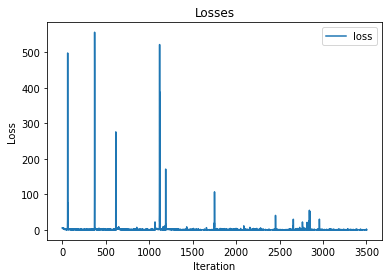

In [74]:
b_results(b)